In [60]:
import pandas as pd
import numpy as np
# Библиотеки для поиска координат по адресу
import requests
import urllib.parse
# Создание колонок с городами и странами
import reverse_geocoder as rg
# Для оценки тональности поста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
# Для поиска паттернов (отлов всех сортов Nothing)
import re
# импорт для работы с кодировщиком (для имен отелей)
import category_encoders as ce 
# label encoding
from sklearn import preprocessing
# распаковка тэгов
import ast

from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
hotels = pd.read_csv('./data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


# Data processing
## NANs


In [99]:
hotels.isna().sum()

additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
review_total_negative_word_counts             0
total_number_of_reviews                       0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
days_since_review                             0
hotel_names_encoded                           0
coord_code                                    0
negative_review_tone                          0
positive_review_tone                          0
dtype: int64

Только два признака? Волшебно! Вытянем недостающие `lat / lng` из адресов отеля. Попробуем это сделать с помощью Nominatim api от open street map.

Искать по полному адресу не всегда получается (там нет знаков препинания и много опечаток -  поисковой движок не понимает), тоже самое и по названию отеля. 

Судя по всему у всех отелей без координат приблизительное положение может быть определенно по последним 3м словам в строке - там находится город, страна и почтовый индекс. Не идеально точно, но более чем достаточно для наших целей.

In [4]:
# создаем словарь с короткими адресами (их будет совсем немного)
addresses = hotels[hotels['lat'].isna()].hotel_address.unique()
short_addresses = set(map(lambda x: " ".join(x.split()[-3:]), addresses))
short_addresses_dict = dict.fromkeys(short_addresses, [])
# pulling coordinates for every adress in the dict 
# (намного экономичнее по времени, чем тянуть данные на каждый отдельный коммент)
for addr in short_addresses_dict.keys():
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(addr) +'?format=json'
    response = requests.get(url).json()
    short_addresses_dict[addr] = [response[0]["lat"], response[0]["lon"]]
    
def fill_columns(row):
    ''' Функция заполняющая пропущенные широту и долготу из словарика с короткими названиями'''
    if (pd.isna(row['lat']) and pd.isna(row['lng'])):
        short_addr = " ".join(row['hotel_address'].split()[-3:])
        if short_addr in list(short_addresses_dict.keys()):
            return pd.Series([float(short_addresses_dict[short_addr][0]), float(short_addresses_dict[short_addr][1])], index=['lat', 'lng'])
        else:
            return pd.Series([row['lat'], row['lng']], index=['lat', 'lng'])
    else:
        return pd.Series([row['lat'], row['lng']], index=['lat', 'lng'])


In [5]:
%%time
# WHY does it take SO LONG? There is not a single loop in there!
hotels[['lat','lng']] = hotels.apply(fill_columns, axis=1)

CPU times: user 1min 48s, sys: 899 ms, total: 1min 49s
Wall time: 1min 49s


In [6]:
# Теперь нам не нужна колонка адресов
hotels.drop('hotel_address', axis=1, inplace=True)

In [7]:
# хотелось бы тоже удалить "hotel_name", но интуиция подсказывает 
# что этот признак очень важен для предсказания
hotels.hotel_name.value_counts()

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: hotel_name, Length: 1492, dtype: int64

In [78]:
# Попробуем его закодировать
# label encoding (random forest понимает категориальные данные, необязательно все переводить в 1 и 0)
label_encoder = preprocessing.LabelEncoder()
hotels['hotel_names_encoded']= label_encoder.fit_transform(hotels['hotel_name'])
# По отдельности lat/lng врятли будут полезны - сольем их в один кат признак.
hotels['coord_code'] = hotels['lat'] * hotels['lng']
hotels['coord_code'] = label_encoder.fit_transform(hotels['coord_code'])
# смотрим во что превратился датафрейм
hotels.head()


,additional_number_of_scoring,review_date,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_names_encoded,...,negative_review_tone,positive_review_tone,review_month,review_day,reviewer_nationality_encoded,acc_type_tag,trip_type_tag,visitors_type_tag,stay_length_tag,mob_dev_tag
0,581,1.455840e+09,8.4,3,1994,4,7,10.0,531,1366,...,-0.3412,0.5859,2,4,28,224,1.0,0,1.0,0.0
1,299,1.484179e+09,8.3,3,1361,2,14,6.3,203,975,...,-0.4767,0.4404,1,3,28,193,0.0,0,0.0,1.0
2,32,1.476749e+09,8.9,6,406,0,14,7.5,289,909,...,-0.2960,0.0000,10,1,4,280,1.0,5,2.0,0.0
3,34,1.442880e+09,7.5,0,607,11,8,10.0,681,983,...,0.0000,0.9169,9,1,28,208,1.0,5,0.0,1.0
4,914,1.457136e+09,8.5,4,7586,20,10,9.6,516,349,...,-0.2500,0.8503,3,5,16,199,0.0,0,5.0,1.0


In [9]:
# дропнем избыточные теперь колонки
hotels.drop(['hotel_name', 'lat', 'lng'], axis=1, inplace=True)

# Преобразование строковых данных. 
## positive_review / negative_review 
Kолонки с отзывами потенциально могут быть очень полезны. Начнем с них.

In [10]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   review_date                                 386803 non-null  object 
 2   average_score                               386803 non-null  float64
 3   reviewer_nationality                        386803 non-null  object 
 4   negative_review                             386803 non-null  object 
 5   review_total_negative_word_counts           386803 non-null  int64  
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  object 
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

Самый популярный негативный отзыв это техническое `No Negative` которое видимо означает что отзыв вообще не был оставлен, все остальные вариации написания слова Nothing видимо оставлены пользователями в качестве скорее позитивной оценки, мол ничего плохого, все ок. 

Учитывая что я потом хочу всунуть данные в `SentimentIntensityAnalyzer` который воспринимает `No Negative` как открыто негативный отзыв а `nothing` как нейтральный, нужно сделать небольшой твик: `No Negative` мы заменим на 0, который выдает интерпретируется как нейтральный отзыв. А все варианты написания nothing мы унифицируем.

У анализатора, есть еще одна ожидаемая слабость - если он видит одно слово типа "завтрак", он не воспринимает его как негативное, но как нейтральное (что логично). Анализатор не знает что речь идет о негативных отзывах. Поэтому можно сделать еще один кульбит и добавить к недостаточно однозначным словам кусочек "was not good". Решая такую же проблему в позитивных отзывах можно добавить туда "was good". Посмотрим, поможет ли.

In [11]:
hotels['negative_review'].value_counts().head(20)

No Negative         95907
 Nothing            10737
 Nothing             3154
 nothing             1660
 N A                  802
 None                 737
                      606
 N a                  384
 Breakfast            296
 Small room           283
 Location             281
 All good             251
 Everything           251
 Nothing really       240
 none                 223
 nothing              219
 No complaints        201
 Nil                  197
 Nothing really       195
 Price                192
Name: negative_review, dtype: int64

In [12]:
def convert_to_nothing(text, pattern, str_to_return):
    # Define a regular expression pattern to match all variants of "nothing" with various spacing and case
    # Check if any matches are found in the text
    
    if pattern.search(text) and len(text.split()) <= 3: # дальше могут начаться сложные предложения, так просто к nothing несводимые
        # If any matches are found, replace the entire text with str_to_return
        return str_to_return
        # If no matches are found, return the original text
    elif (text.strip() == 'No Positive') or (text.strip() == 'No Negative'):
        return '0'
    else:
        return text
    
def review_enchancer(text, tone=True):
    ''' Усиливает неоднозначные односложные функции'''
    if (len(text.split()) == 1) and (tone == True) and text != '0':
        return text + " was good"
    elif (len(text.split()) == 1) and (tone == False) and text != '0':
        return text + " was not good"
    else:
        return text
    



In [13]:
pat = re.compile(r'\b(nothing|nil|na|n a|nil|nope|none|no complaint|no complaints)\b', re.IGNORECASE)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: convert_to_nothing(x, pat, 'nothing'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: review_enchancer(x, tone=False))

In [14]:
hotels['negative_review'].value_counts().head(20)

0                            95909
nothing was not good         22085
                               606
 Breakfast was not good        298
 Small room                    283
 Location was not good         281
 All good                      251
 Everything was not good       251
 Price was not good            192
 Small rooms                   135
 All good                      116
 Expensive was not good        105
 Room size                     103
 Can t think of anything       103
 Very small room                98
 Everything was perfect         97
 Staff was not good             93
 Everything was great           89
 No was not good                89
 Everything was perfect         88
Name: negative_review, dtype: int64

Засовываем в анализатор

In [15]:
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

hotels['negative_review_tone'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lamewarden/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# посмотри если нет вопиющих ошибок
hotels[['negative_review_tone', 'negative_review']]

,negative_review_tone,negative_review
0,-0.3412,Leaving was not good
1,-0.4767,poor breakfast
2,-0.2960,No kettle in room
3,0.0000,0
4,-0.2500,Torn sheets
...,...,...
386798,0.0000,0
386799,0.0000,0
386800,0.0000,room is really small but guess is normal in L...
386801,0.0000,0


Выглядит океюшно. Поехали на позитивные отзывы.

In [17]:
hotels['positive_review'].value_counts().head(20)

No Positive            26885
 Location               6833
 Everything             1697
 location               1251
 Nothing                 931
 The location            830
 Great location          809
 Good location           690
 Location                663
 Breakfast               455
 Everything              449
 Friendly staff          385
 Staff                   347
 Excellent location      296
 Great location          280
 Location and staff      256
 everything              233
 Good location           214
 Nothing                 170
 nothing                 159
Name: positive_review, dtype: int64

In [18]:
# тавтологичных оценок сильно меньше, поэтому не будем делать избыточную работу
# на первом этапе просто закодируем отсутствие отзыва на 0 как в негативных отзывах
hotels['positive_review'] = hotels['positive_review'].apply(lambda text : '0' if text.strip() == 'No Positive' else text)
# теперь проведем обработку "неоднозначных" значений
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: review_enchancer(x, tone=True))

In [19]:
hotels['positive_review'].value_counts().head(20)

0                        26885
 Location was good        6973
 Everything was good      1737
 location was good        1271
 Nothing was good          931
 The location              830
 Great location            809
 Good location             690
 Location  was good        663
 Breakfast was good        554
 Everything  was good      449
 Friendly staff            385
 Staff was good            349
 Excellent location        296
 Great location            280
 Location and staff        256
 everything was good       237
 Good location             214
 Nothing  was good         170
 nothing was good          159
Name: positive_review, dtype: int64

In [20]:
# Теперь анализатор тональности
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

hotels['positive_review_tone'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lamewarden/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# посмотрим если нет вопиющих ошибок
hotels[['positive_review_tone', 'positive_review']]

,positive_review_tone,positive_review
0,0.5859,Staff were amazing
1,0.4404,location was good
2,0.0000,0
3,0.9169,Friendly staff quiet comfortable room spotles...
4,0.8503,The staff was very friendly and helpful Break...
...,...,...
386798,0.0000,Tr s proche du metro Earl s court
386799,0.7264,The bed was so comfy I stayed with my boyfrie...
386800,0.7845,great location simple check in out nice shower
386801,0.0000,Location and very comfy bed


In [22]:
# думаю оригинальные колонки отзывов можно удалять - я не знаю что еще из них можно вытянуть
hotels = hotels.drop(['positive_review', 'negative_review'], axis = 1)
# попробуем вывести общую оценку?
hotels['review_tone_sum'] = hotels['positive_review_tone'] + hotels['negative_review_tone']

## `review_date`
Отсюда можно вытащить горы интересных данных. 
1.  Собственно время, переведем его в стандарт юникс тип и нормализуем;
2.  Вытянем столбец с месяцем - одно и то же место может ощущаться очень по-разному в Декабре и Июне;
3.  Вытянем день недели - по собственному опыту знаю, что отзыв пишется или в день поездки или 1-2 дня после, то есть коррелирует со днями недели в которые человек в отеле останавливался. Логично предположить, что те, кто приехал куда-то на выходные будут иметь немного другие ожидания, чем те, кто путешествует по работе в будни.
4. Год? Как мы знаем ковидный год для туристов это вобще не стандартный год. Значения в зависимости от года тоже могут отличаться.
### Выделяем время:

In [23]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=False)

In [24]:
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.weekday
hotels['review_year'] = hotels['review_date'].dt.year
# now converting it into standart unix time:
hotels['review_date']= hotels['review_date'].apply(lambda x: x.timestamp())
# нормализацией займемся позже

## `reviewer_nationality`
Ну что, добавим немного бытового расизма?
Стран откуда приехали гости много, но распределение очень сильно смещено к первой десятке. В первые 30 стран входит почти 90% всех отзывов.

In [25]:
top_countries = list(hotels.reviewer_nationality.value_counts().head(30).keys())
top_number = hotels[hotels['reviewer_nationality'].isin(top_countries)].shape[0]
rest_number = hotels[hotels['reviewer_nationality'].isin(top_countries) == False].shape[0]
print(f"Top 30 countries are responsible for {round(top_number/(top_number+rest_number),4)*100}% of all reviewes")

Top 30 countries are responsible for 88.08% of all reviewes


Оставим первую 30-ку как есть, остальные переименуем в 'other'

In [26]:
hotels.loc[~hotels['reviewer_nationality'].isin(top_countries), 'reviewer_nationality'] = 'other'

"Оцифруем" признак через label encoding:

In [27]:
label_encoder = preprocessing.LabelEncoder()
hotels['reviewer_nationality_encoded']= label_encoder.fit_transform(hotels['reviewer_nationality'])

In [28]:
# избавляемся от reviewer_nationality
hotels.drop('reviewer_nationality', axis=1, inplace=True)

In [29]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   review_date                                 386803 non-null  float64
 2   average_score                               386803 non-null  float64
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   review_total_positive_word_counts           386803 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 7   reviewer_score                              386803 non-null  float64
 8   tags                                        386803 non-null  object 
 9   days_since_review                           386803 non-null  object 
 

## `tags`

In [30]:
# превращаем список в список (в оригинале это была строка)
hotels['tags'] = hotels['tags'].apply(lambda x: ast.literal_eval(x))

Если приглядеться к этому списку повнимательнее, то становится очевидно, что это не просто рандомный мешок с тэгами. Пытаясь посчитать самые популярные тэги я перевел каждый лист в series объект и вывел их друг над другом как датафрейм. 

In [31]:
tags_df = hotels["tags"].apply(pd.Series)
tags_df.columns = ["Тип поездки", "Количество гостей", "Тип квартиры",  "Длина визита", "Отправлено с устройства ...", 'other']
tags_df

,Тип поездки,Количество гостей,Тип квартиры,Длина визита,Отправлено с устройства ...,other
0,Leisure trip,Couple,Studio Suite,Stayed 2 nights,Submitted from a mobile device,NaN
1,Business trip,Couple,Standard Double Room,Stayed 1 night,NaN,NaN
2,Leisure trip,Solo traveler,Modern Double Room Echo,Stayed 3 nights,Submitted from a mobile device,NaN
3,Leisure trip,Solo traveler,Standard Room with 1 Double Bed,Stayed 1 night,NaN,NaN
4,Business trip,Couple,Standard Double or Twin Room,Stayed 6 nights,NaN,NaN
...,...,...,...,...,...,...
386798,Leisure trip,Group,Club Double or Twin Room,Stayed 2 nights,Submitted from a mobile device,NaN
386799,Leisure trip,Couple,Standard Double Room,Stayed 4 nights,Submitted from a mobile device,NaN
386800,Business trip,Solo traveler,Single Room,Stayed 1 night,NaN,NaN
386801,Leisure trip,Solo traveler,Deluxe Double Room,Stayed 2 nights,NaN,NaN


У такого датафрейма однако есть проблемы - кое-где есть пропущенные теги и весь порядок тегов уехал вправо.
Попробуем рассортировать значения, предварительно создав словарь всех значений, входящих в соответствующую категорию.



Сначала создадим мешок со всеми тэгами вообще:

In [32]:
tag_set = set()
for a in range(0,6):
    for key in tags_df.iloc[:,a].value_counts().keys():
        tag_set.add(key)
        
print(len(tag_set))

2368


In [33]:
# Тип поездки - очевидно что родные тут только первые две категории, остальное "приехало" из колонки справа
tags_df.iloc[:,0].value_counts()

 Leisure trip                   312768
 Business trip                   61846
 Couple                           4346
 Solo traveler                    3216
 Family with young children       1660
 Group                            1188
 With a pet                       1045
 Family with older children        689
 Travelers with friends             45
Name: Тип поездки, dtype: int64

In [34]:
# создадим сет признаков которые должны быть в первой колонке
trip_type = set(tags_df.iloc[:,0].value_counts().head(2).keys())
# остальное сразу добавим в сет для второй колонки
visitors_type = set(tags_df.iloc[:,0].value_counts().keys()[2:])
# удалим признаки первой колонки из общего мешка
tag_set -= trip_type
# порядок элементов в сете будет скакать, а нам это для дальнейшей работы не нужно
trip_type = list(trip_type)
len(tag_set)

2366

In [35]:
# Вторая колонка - Количество гостей. Какое то количество этих тэгов мы уже перехватили в первую колонке.
# Посмотрим есть ли какие-то дополнительные во второй.
tags_df.iloc[:,1].value_counts().head(30)
# Нету, мы пособирали все. Вычтем гостевые теги из общего мешка и переведем в лист для удобства.
tag_set -= visitors_type
visitors_type = list(visitors_type)
len(tag_set)

2359

In [36]:
# Типов квартир (3я колонка) - очень много, возьmемся за них потом методом исключения
# Посмотрим на колонку длиной визита (4ю колонку)
tags_df.iloc[:,3].value_counts().head(10)

 Stayed 1 night                     140089
 Stayed 2 nights                     97500
 Stayed 3 nights                     70153
 Stayed 4 nights                     34789
 Stayed 5 nights                     15171
 Stayed 6 nights                      7115
 Submitted from a mobile device       7083
 Stayed 7 nights                      5319
 Stayed 8 nights                      1823
 Stayed 9 nights                       916
Name: Длина визита, dtype: int64

In [37]:
# тут тоже есть левые значения, но нужную информацию будет просто вытянуть просто по слову stayed, 
# тут даже regex не нужен
stay_length = {stay for stay in tag_set if 'Stayed' in stay}
# удалим их из общего мешка
tag_set -= stay_length
stay_length = list(stay_length)
# Выглядит как ординальный признак, отсортируем его по количеству ночей по восходящей
stay_length.sort(key=lambda x: int(x.split()[1]))
len(tag_set)

2329

In [38]:
# Остается пятая колонка где 223052 значений заполнено строкой Submitted from a mobile device. 
tags_df.iloc[:,4].value_counts().head(10)
# Судя по всему колонка отвечает только за это. Странно, но нам же лучше - проще будет кодировать.

 Submitted from a mobile device     223052
 Stayed 1 night                        405
 Stayed 2 nights                       265
 Stayed 3 nights                       164
 Stayed 4 nights                        70
 Stayed 5 nights                        30
 Stayed 6 nights                        12
 Stayed 7 nights                        10
 Stayed 8 nights                         3
 Stayed 9 nights                         3
Name: Отправлено с устройства ..., dtype: int64

In [39]:
mob_dev = tags_df.iloc[:,4].value_counts().keys()[0]
# удалим eго из общего мешка
tag_set.remove(mob_dev)
len(tag_set)

2328

В пятой колонке никаких уникальных значений не осталось, а это значит что мы учли все и остаток нашего мешка сетов это исключительно названия типов квартир.

In [40]:
tags_df.iloc[:,5].value_counts().head(10)

 Submitted from a mobile device     563
Name: other, dtype: int64

In [41]:
# Вернемся к Типам квартир (3я колонка). Их очень много, а потому для них мы изменим подход немного - 
# мы сначала полностью заполним соответсвующую колонку всеми найденными тэгами 
# (они были размазаны на 3 колонки)
def tag_gatherer(x, tag_lst):
    for tag in x:
        if tag in tag_lst:
            return tag
        else:
            pass
# Типы комнат
acc_type = list(tag_set)
hotels['acc_type_tag'] = hotels['tags'].apply(lambda x: tag_gatherer(x, acc_type))

In [42]:
# теперь чтобы не кодировать все 2.5к тэгов, выберем только те, кто составляет 90% всех значений
# Найдем ключ последнего из топ Н значений, составляющих первые 90 % значений
cum_sum = 0
for key, value in hotels['acc_type_tag'].value_counts().items():
    if cum_sum / hotels['acc_type_tag'].shape[0] < 0.9:
        cum_sum+=value
    else:
        break
# Засунем все топ значения в лист
top_90_lst = list(hotels['acc_type_tag'].value_counts()[:key].keys())
# заменим все что не входит в топ_90% на other
hotels['acc_type_tag'] = hotels['acc_type_tag'].apply(lambda x: x if x in top_90_lst else 'other')

In [43]:
# И вот теперь наконец закодируем колонку типа проживания
# тут уже можно воспользовпаться просто LabelEncoder()
label_encoder = preprocessing.LabelEncoder()
hotels['acc_type_tag'] = label_encoder.fit_transform(hotels['acc_type_tag'])

Теперь сделаем ручное label кодирование остальных признаков

In [44]:
# Простенький кодировщик - можно было написать лямбдой, но неохота была городить,
# так читабельнее
def label_coder(x, tag_lst):
    for tag in x:
        if tag in tag_lst:
            return tag_lst.index(tag)
        else:
            pass

In [45]:
# Тип поездки
hotels['trip_type_tag'] = hotels['tags'].apply(lambda x: label_coder(x, trip_type))
# Количество гостей
hotels['visitors_type_tag'] = hotels['tags'].apply(lambda x: label_coder(x, visitors_type))
# Длина проживания
hotels['stay_length_tag'] = hotels['tags'].apply(lambda x: label_coder(x, stay_length))
# Написано на телефоне
hotels['mob_dev_tag'] = hotels['tags'].apply(lambda x: label_coder(x, mob_dev))
# Дропаем колонку с тэгами 
hotels.drop('tags', axis=1, inplace=True)

Теперь проверим полученные колонки на пропуски

In [46]:
hotels.loc[:,'acc_type_tag':].isna().sum()

acc_type_tag              0
trip_type_tag         11221
visitors_type_tag         0
stay_length_tag         146
mob_dev_tag          156025
dtype: int64

`trip_type_tag` 
Когда человек едет по работе, он обычно не забывает поставить нужный тэг - так как рабочие поездки ему оплачиваются в бухгалтерии, которой нужно относить все бумажки. А если человек едет на отдых, он может просто забить на любые пометки. Плюс соотношение leasure trip к Bussiness trip - 4 к 1.

Поэтому - решено
* Забиваем в `trip_type_tag` все пропуски нулями (которые значат отдых);

* В `stay_length_tag`  - модой (там пропусков - кот наплакал, ничего не испортим);

* В  `mob_dev_tag` - пропусков почти половина, что видимо значит что отзыв написан не с телефона, а с другого устройства, дадим этому "другому устройству" код 1

In [47]:
# trip_type_tag
hotels.loc[hotels['trip_type_tag'].isna() == True, 'trip_type_tag'] = 0
# stay_length_tag
hotels.loc[hotels['stay_length_tag'].isna() == True, 'stay_length_tag'] = hotels['stay_length_tag'].mode()[0]
# mob_dev_tag
hotels.loc[hotels['mob_dev_tag'].isna() == True, 'mob_dev_tag'] = 1

In [48]:
hotels.loc[:,'trip_type_tag':].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_type_tag      386803 non-null  float64
 1   visitors_type_tag  386803 non-null  int64  
 2   stay_length_tag    386803 non-null  float64
 3   mob_dev_tag        386803 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 11.8 MB


## `days_since_review`
Тут все просто, выделяем числовоую часть и переводим в числа.

In [49]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

# Отбор признаков
## Проверка на мультиколлинеарность

In [56]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   review_date                                 386803 non-null  float64
 2   average_score                               386803 non-null  float64
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   review_total_positive_word_counts           386803 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 7   reviewer_score                              386803 non-null  float64
 8   days_since_review                           386803 non-null  int64  
 9   hotel_names_encoded                         386803 non-null  int64  
 

In [65]:
# Разделим признакм на непрерывные и категориальные (для них нужны будут разные подсчеты корреляции)
# категориальные признаки (почти все что у нас есть)
cat_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'additional_number_of_scoring'
            ,'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review'
            ,'hotel_names_encoded', 'coord_code', 'review_month','review_day', 'review_year', 'reviewer_nationality_encoded'
            , 'acc_type_tag', 'trip_type_tag', 'visitors_type_tag', 'stay_length_tag', 'mob_dev_tag']

# непрерывные признаки
cont_cols = ['average_score', 'review_tone_sum', 'positive_review_tone', 'negative_review_tone', 'average_score']

<AxesSubplot:>

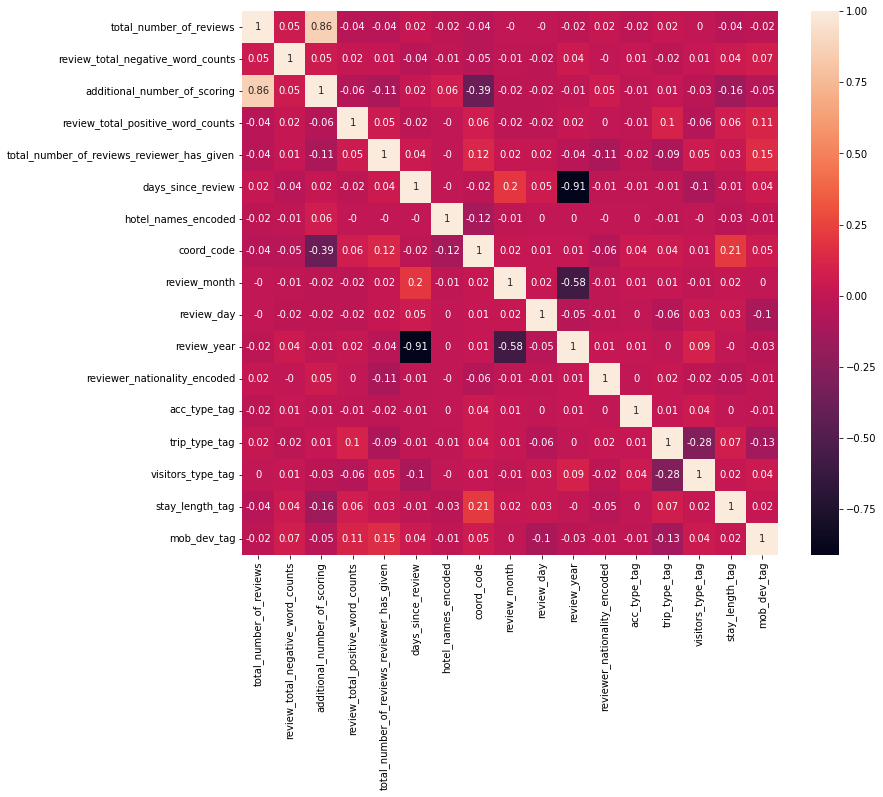

In [64]:
# Смотрим на корреляцию категориальных дат. Для этого используем корреляцию Спирмена
plt.figure(figsize=(12,10))
sns.heatmap(round(hotels[cat_cols].corr('spearman'), 2), annot=True) 


<AxesSubplot:>

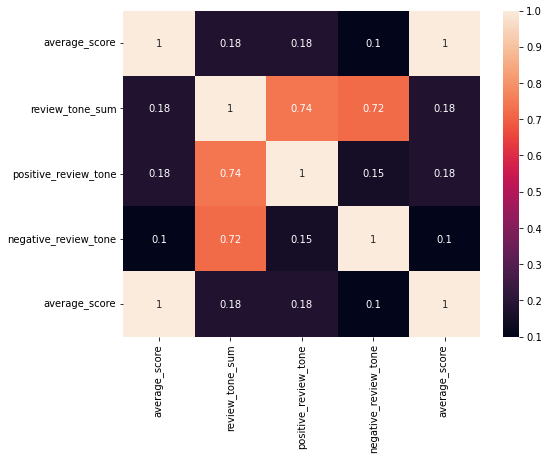

In [66]:
# Смотрим на корреляцию непрерывных дат. Для этого используем корреляцию Пирсона
plt.figure(figsize=(8,6))
sns.heatmap(round(hotels[cont_cols].corr('spearman'), 2), annot=True) 

По результатам:
### Категориальные признаки:

Высокая скоррелированность наблюдается между day_since_review и review_year.

Удалим review year.

### Непрерывные признаки:
Высокая скоррелированность наблюдается между negative/positive_review_tone и review_tone_sum (что было ожидаемо).

Удалим review_tone_sum.


In [75]:
hotels = hotels.drop(['review_year', 'review_tone_sum'], axis=1)
# обновляем списки колонок
cont_cols.remove('review_tone_sum')
cat_cols.remove('review_year')

In [74]:
cont_cols

['average_score',
 'positive_review_tone',
 'negative_review_tone',
 'average_score']

In [80]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

<AxesSubplot:>

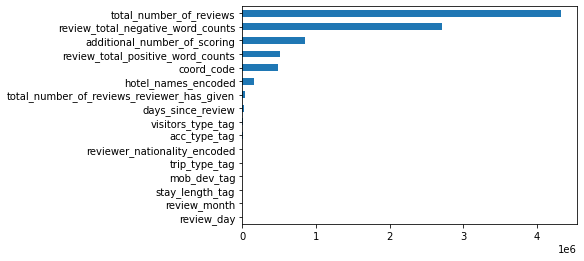

In [82]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

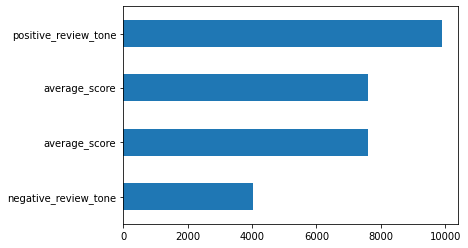

In [84]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[cont_cols], y)[0], index = cont_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Выводы:
### Категориальные:
Теги нерелевантны, так же как и дни с месяцами. Удалим их.
### Непрерывные
У непрерывных нет значений "совсем на дне". Оставим все.

In [93]:
# Удаляем нижние 8 категориальных аутсайдеров:
outsiders = list(imp_cat.head(8).keys())
hotels = hotels.drop(outsiders, axis=1)

In [94]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [95]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [96]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [97]:
%%time
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


CPU times: user 4min 28s, sys: 811 ms, total: 4min 29s
Wall time: 4min 30s


In [98]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12394111240367851


Небольшой бонус:


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)